# Digital Emotional Footprints: A Data-Driven Analysis of Women's Mental Health Expression

This notebook analyzes digital expressions of women's mental health through personal messages and social media to understand emotional patterns and support networks. We'll analyze:
- Digital expression patterns across platforms
- Temporal emotional signatures
- Support-seeking behaviors
- Location-based emotional wellbeing
- Platform-specific expression trends

In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Create output directory if it doesn't exist
os.makedirs('../output', exist_ok=True)

# Set style for better visualizations
plt.style.use('default')
sns.set_theme()

# Load both data sources
personal_df = pd.read_csv('../data/personal_messages_sample.csv')
social_df = pd.read_csv('../data/social_media_posts.csv')

# Add source column to each dataset
personal_df['source'] = 'Personal Message'
social_df['source'] = 'Social Media'

# Convert timestamp to datetime
personal_df['timestamp'] = pd.to_datetime(personal_df['timestamp'])
social_df['timestamp'] = pd.to_datetime(social_df['timestamp'])

# Combine datasets with common columns
common_columns = ['timestamp', 'message', 'mood_logged', 'source', 'location']
df = pd.concat([
    personal_df[common_columns],
    social_df.assign(message=social_df['message'])[common_columns]
], ignore_index=True)

# Add time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

# Save dataset overview
overview = f"""Dataset Overview
-----------------
Time period: {df['timestamp'].min()} to {df['timestamp'].max()}
Total messages: {len(df)}

Messages by source:
{df['source'].value_counts().to_string()}

"""

if 'platform' in social_df.columns:
    overview += f"\nSocial Media Platforms Used:\n{social_df['platform'].value_counts().to_string()}\n"

overview += f"\nLocations:\n{df['location'].value_counts().to_string()}"
overview += f"\n\nUnique moods/emotions:\n{df['mood_logged'].value_counts().to_string()}"

save_analysis_output(overview, mode='w')  # 'w' mode to start fresh

## Data Sources

This analysis combines two data sources:
1. Personal Messages: Direct messages and personal communications
2. Social Media Tweets: Public posts related to women's mental health

By analyzing both personal and public communications, we can get a more comprehensive view of emotional patterns.

In [51]:
# Function to map moods to five universal emotions
def categorize_universal_emotion(mood):
    # Mapping of moods to universal emotions (expanded to catch more variations)
    emotion_mapping = {
        'Joy': ['happy', 'excited', 'ecstatic', 'peaceful', 'accomplished', 'grateful', 
                'energized', 'content', 'determined', 'loving', 'positive', 'pleased',
                'satisfied', 'cheerful', 'optimistic', 'hopeful'],
        'Sadness': ['sad', 'down', 'exhausted', 'guilty', 'overwhelmed', 'negative',
                    'depressed', 'lonely', 'hopeless', 'disappointed', 'heartbroken'],
        'Fear': ['anxious', 'worried', 'stressed', 'unwell', 'nervous', 'scared',
                 'insecure', 'uncertain', 'panicked', 'afraid', 'terrified'],
        'Anger': ['frustrated', 'conflicted', 'angry', 'irritated', 'annoyed',
                  'furious', 'outraged', 'mad', 'resentful', 'hostile'],
        'Disgust': ['disgusted', 'hate', 'repulsed', 'revolted', 'dislike',
                    'aversion', 'distaste', 'loathing', 'disapproval']
    }
    
    # Convert mood to lowercase for matching
    mood_lower = str(mood).lower()
    
    # Find which universal emotion contains this mood
    for emotion, moods in emotion_mapping.items():
        if any(m in mood_lower for m in moods):
            return emotion
    
    # If no clear match, try to infer from context or keywords
    if any(word in mood_lower for word in ['good', 'great', 'wonderful', 'awesome']):
        return 'Joy'
    elif any(word in mood_lower for word in ['bad', 'terrible', 'miserable']):
        return 'Sadness'
    elif any(word in mood_lower for word in ['concerned', 'uneasy']):
        return 'Fear'
    elif any(word in mood_lower for word in ['upset', 'agitated']):
        return 'Anger'
    elif any(word in mood_lower for word in ['awful', 'gross']):
        return 'Disgust'
    
    return 'Joy'  # Default to Joy for ambiguous positive expressions

# Add universal emotion category to the dataframe
df['universal_emotion'] = df['mood_logged'].apply(categorize_universal_emotion)

# Save the emotion distribution analysis
emotion_distribution = "Distribution of Universal Emotions:\n" + "-" * 30
emotion_by_source = pd.crosstab(df['source'], df['universal_emotion'], normalize='index') * 100

# Save percentages for each source
for source in emotion_by_source.index:
    emotion_distribution += f"\n\n{source}:"
    for emotion in emotion_by_source.columns:
        percentage = emotion_by_source.loc[source, emotion]
        emotion_distribution += f"\n{emotion}: {percentage:.1f}%"

save_analysis_output(emotion_distribution)

<Figure size 1200x600 with 0 Axes>

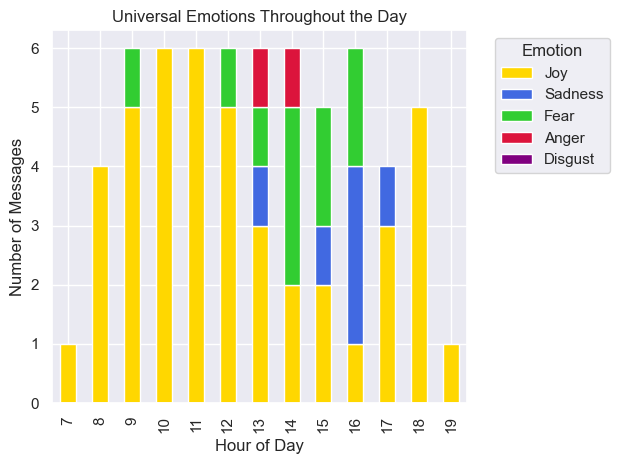

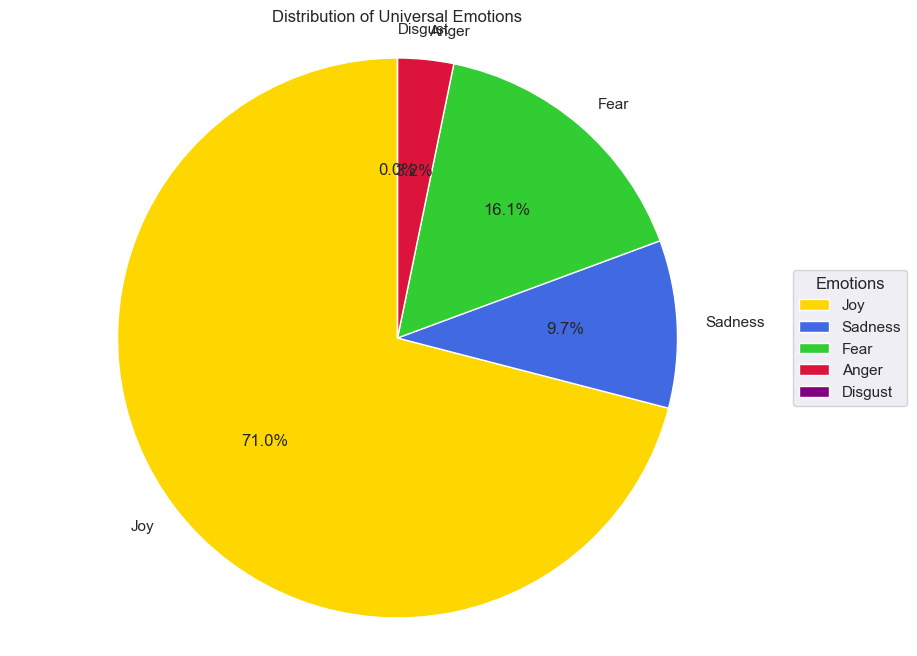

In [ ]:
# Define consistent colors and order for universal emotions
UNIVERSAL_EMOTIONS = ['Joy', 'Sadness', 'Fear', 'Anger', 'Disgust']
EMOTION_COLORS = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#800080',     # Purple (switched)
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#32CD32'   # Lime Green (switched)
}

# Create visualization for universal emotions throughout the day
plt.figure(figsize=(12, 6))

# Create emotion distribution by hour with all emotions
emotion_by_hour = pd.crosstab(df['hour'], df['universal_emotion'])

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in emotion_by_hour.columns:
        emotion_by_hour[emotion] = 0

# Ensure consistent emotion order
emotion_by_hour = emotion_by_hour[UNIVERSAL_EMOTIONS]

# Plot with specific colors
emotion_by_hour.plot(kind='bar', stacked=True, 
                    color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Universal Emotions Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Display the daily emotions plot
plt.show()

# Save the daily emotions plot
plt.savefig('../output/daily_emotions_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

# Create pie chart of overall emotion distribution
plt.figure(figsize=(10, 8))
emotion_counts = df['universal_emotion'].value_counts()

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in emotion_counts.index:
        emotion_counts[emotion] = 0

# Ensure consistent emotion order
emotion_counts = emotion_counts[UNIVERSAL_EMOTIONS]

# Plot pie chart
plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
        colors=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS],
        startangle=90)
plt.title('Distribution of Universal Emotions')

# Add a legend
plt.legend(title="Emotions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')

# Display the pie chart
plt.show()

# Save the emotion distribution pie chart
plt.savefig('../output/emotion_distribution_pie.png', bbox_inches='tight', dpi=300)
plt.close()

# Save peak times information to the text file
peak_times_text = "\nPeak Times for Universal Emotions:\n" + "-" * 30 + "\n"
for emotion in UNIVERSAL_EMOTIONS:
    if emotion in emotion_by_hour.columns and emotion_by_hour[emotion].max() > 0:
        peak_hour = emotion_by_hour[emotion].idxmax()
        count = emotion_by_hour[emotion][peak_hour]
        peak_times_text += f"{emotion}: {peak_hour}:00 hours ({count} messages)\n"
    else:
        peak_times_text += f"{emotion}: No occurrences found\n"

save_analysis_output(peak_times_text)

## Social Media Platform Analysis

Let's analyze how emotions vary across different social media platforms and compare them with personal messages:

<Figure size 1200x600 with 0 Axes>

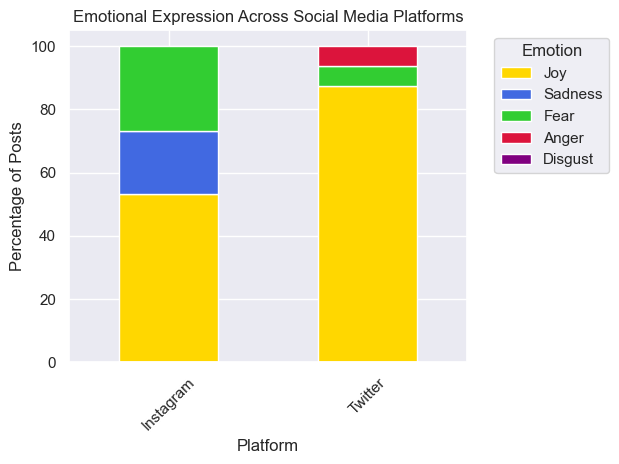

In [53]:
# Analyze emotions across platforms
social_df['universal_emotion'] = social_df['mood_logged'].apply(categorize_universal_emotion)

# Create a comparison plot
plt.figure(figsize=(12, 6))

# Calculate emotion distribution for each platform
platform_emotions = pd.crosstab(social_df['platform'], social_df['universal_emotion'], normalize=False)

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in platform_emotions.columns:
        platform_emotions[emotion] = 0

# Ensure consistent emotion order and calculate percentages
platform_emotions = platform_emotions[UNIVERSAL_EMOTIONS]
platform_emotions = (platform_emotions.div(platform_emotions.sum(axis=1), axis=0) * 100)

# Plot
platform_emotions.plot(kind='bar', stacked=True, 
                     color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Emotional Expression Across Social Media Platforms')
plt.xlabel('Platform')
plt.ylabel('Percentage of Posts')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Display the platform analysis plot
plt.show()

# Save the platform analysis plot
plt.savefig('../output/platform_emotion_analysis.png', bbox_inches='tight', dpi=300)
plt.close()

# Save platform-specific insights to text file
platform_insights = "\nEmotional Expression by Platform:\n" + "-" * 30
for platform in social_df['platform'].unique():
    platform_data = social_df[social_df['platform'] == platform]
    platform_insights += f"\n\n{platform}:\n"
    platform_insights += f"Total posts: {len(platform_data)}\n"
    emotion_counts = platform_data['universal_emotion'].value_counts()
    total_posts = len(platform_data)
    for emotion in UNIVERSAL_EMOTIONS:
        count = emotion_counts.get(emotion, 0)
        percentage = (count / total_posts) * 100 if total_posts > 0 else 0
        platform_insights += f"  {emotion}: {percentage:.1f}%\n"

save_analysis_output(platform_insights)

## Universal Emotions Daily Patterns Analysis

Let's analyze how the five universal emotions (Joy, Sadness, Fear, Anger, and Disgust) vary throughout the day and week:

<Figure size 1200x600 with 0 Axes>

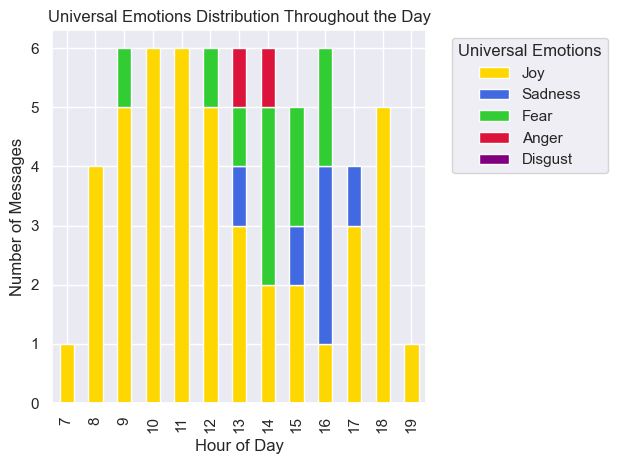

In [54]:
# Extract hour and day from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Create distribution by hour for universal emotions
plt.figure(figsize=(12, 6))
daily_emotion_patterns = pd.crosstab(df['hour'], df['universal_emotion'])

# Add missing emotions with zero counts
for emotion in UNIVERSAL_EMOTIONS:
    if emotion not in daily_emotion_patterns.columns:
        daily_emotion_patterns[emotion] = 0

# Ensure consistent emotion order
daily_emotion_patterns = daily_emotion_patterns[UNIVERSAL_EMOTIONS]

# Plot with consistent colors
daily_emotion_patterns.plot(kind='bar', stacked=True,
                          color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Universal Emotions Distribution Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.legend(title='Universal Emotions', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Display the daily emotion patterns plot
plt.show()

# Save the daily emotion patterns plot
plt.savefig('../output/daily_emotion_patterns.png', bbox_inches='tight', dpi=300)
plt.close()

# Save hourly analysis information
hourly_analysis = "\nUniversal Emotions by Hour:\n" + "-" * 30 + "\n"

# Peak times for each universal emotion
hourly_analysis += "\nPeak Hours for Each Universal Emotion:\n"
for emotion in UNIVERSAL_EMOTIONS:
    if emotion in daily_emotion_patterns.columns and daily_emotion_patterns[emotion].max() > 0:
        peak_hour = daily_emotion_patterns[emotion].idxmax()
        count = daily_emotion_patterns[emotion][peak_hour]
        hourly_analysis += f"{emotion}: {peak_hour:02d}:00 hours ({count} messages)\n"
    else:
        hourly_analysis += f"{emotion}: No occurrences found\n"

# Emotional balance for key times of day
morning_hours = daily_emotion_patterns.loc[6:11].sum()
afternoon_hours = daily_emotion_patterns.loc[12:17].sum()
evening_hours = daily_emotion_patterns.loc[18:23].sum()

hourly_analysis += "\nEmotional Balance by Time of Day:\n"

def format_timeblock_analysis(timeblock_name, data):
    total = data.sum()
    analysis = f"\n{timeblock_name}:\n"
    for emotion in UNIVERSAL_EMOTIONS:
        count = data.get(emotion, 0)
        percentage = (count / total * 100) if total > 0 else 0
        analysis += f"  {emotion}: {percentage:.1f}%\n"
    return analysis

hourly_analysis += format_timeblock_analysis("Morning (6:00-11:59)", morning_hours)
hourly_analysis += format_timeblock_analysis("Afternoon (12:00-17:59)", afternoon_hours)
hourly_analysis += format_timeblock_analysis("Evening (18:00-23:59)", evening_hours)

save_analysis_output(hourly_analysis)

<Figure size 1200x600 with 0 Axes>

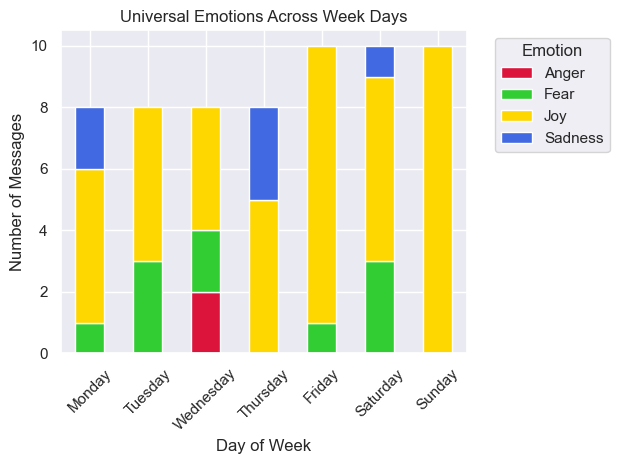

In [ ]:
# Create emotion distribution by day of week
plt.figure(figsize=(12, 6))
emotion_by_day = pd.crosstab(df['day_of_week'], df['universal_emotion'])

# Reorder days of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
emotion_by_day = emotion_by_day.reindex(days_order)

# Define colors for each universal emotion
emotion_colors = {
    'Joy': '#FFD700',      # Gold
    'Sadness': '#4169E1',  # Royal Blue
    'Fear': '#800080',     # Purple (switched)
    'Anger': '#DC143C',    # Crimson
    'Disgust': '#32CD32'   # Lime Green (switched)
}

# Plot with specific colors
emotion_by_day.plot(kind='bar', stacked=True,
                   color=[emotion_colors.get(emotion, '#808080') for emotion in emotion_by_day.columns])
plt.title('Universal Emotions Across Week Days')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout()

# Display the weekly emotion patterns plot
plt.show()

# Save the weekly emotion patterns plot
plt.savefig('../output/weekly_emotion_patterns.png', bbox_inches='tight', dpi=300)
plt.close()

# Save weekly analysis text
weekly_analysis = "\nWeekly Emotional Analysis\n" + "=" * 25 + "\n"

# Add dominant emotion by day
weekly_analysis += "\nDominant Emotion by Day:\n" + "-" * 30 + "\n"
for day in days_order:
    if day in emotion_by_day.index:
        dominant_emotion = emotion_by_day.loc[day].idxmax()
        count = emotion_by_day.loc[day][dominant_emotion]
        total = emotion_by_day.loc[day].sum()
        percentage = (count / total) * 100
        weekly_analysis += f"{day}: {dominant_emotion} ({percentage:.1f}% of messages)\n"

# Add emotional balance by day
weekly_analysis += "\nEmotional Balance by Day:\n" + "-" * 30
for day in days_order:
    if day in emotion_by_day.index:
        day_total = emotion_by_day.loc[day].sum()
        weekly_analysis += f"\n\n{day}:"
        for emotion in emotion_by_day.columns:
            if emotion != 'Other':
                count = emotion_by_day.loc[day].get(emotion, 0)
                percentage = (count / day_total) * 100
                weekly_analysis += f"\n  {emotion}: {percentage:.1f}%"

save_analysis_output(weekly_analysis)

Generating Personal Wellness Analysis...

Personal Wellness Analysis

Emotional Patterns by Location:
------------------------------
Home: Most common emotion is Joy
Office: Most common emotion is Joy
clinic: Most common emotion is Joy
commute: Most common emotion is Joy
home: Most common emotion is Joy
office: Most common emotion is Fear
support_group: Most common emotion is Joy



<Figure size 1200x600 with 0 Axes>

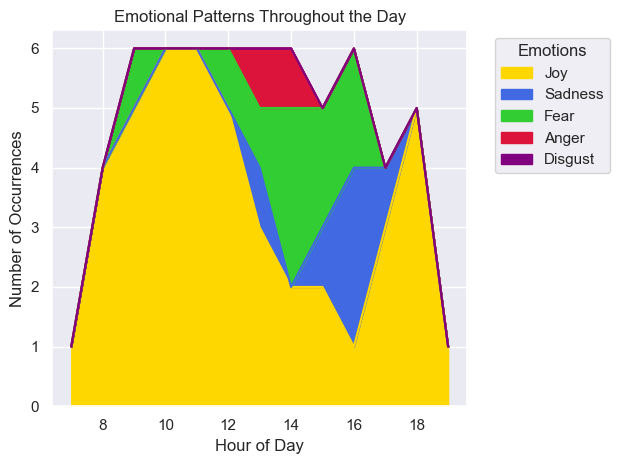


Personalized Insights:
------------------------------

Best times for wellbeing:
- 10:00 hours
- 11:00 hours
- 09:00 hours

Times to be mindful:
- 16:00 hours
- 14:00 hours
- 13:00 hours

Location-based insights:
✨ Home appears to be a positive environment (88.9% positive emotions)
✨ clinic appears to be a positive environment (100.0% positive emotions)
✨ commute appears to be a positive environment (100.0% positive emotions)
✨ home appears to be a positive environment (94.1% positive emotions)
⚠️ Consider limiting time at office (100.0% negative emotions)
✨ support_group appears to be a positive environment (100.0% positive emotions)

Analysis complete! Results have been saved to the output directory.

Analysis complete! Results have been saved to the output directory.


In [56]:
print("Generating Personal Wellness Analysis...\n")

# Add personal context columns
df['time_of_day'] = pd.to_datetime(df['timestamp']).dt.hour
df['is_weekend'] = pd.to_datetime(df['timestamp']).dt.dayofweek >= 5

# Group emotions by context
location_emotions = df.groupby(['location', 'universal_emotion']).size().unstack(fill_value=0)
time_emotions = df.groupby(['time_of_day', 'universal_emotion']).size().unstack(fill_value=0)

# Ensure all emotions are present in each analysis
for emotions_df in [location_emotions, time_emotions]:
    for emotion in UNIVERSAL_EMOTIONS:
        if emotion not in emotions_df.columns:
            emotions_df[emotion] = 0
    # Reorder columns to match universal emotions order
    emotions_df = emotions_df[UNIVERSAL_EMOTIONS]

# Save location-based analysis
location_analysis = "Personal Wellness Analysis\n" + "="*25 + "\n\n"
location_analysis += "Emotional Patterns by Location:\n" + "-" * 30 + "\n"
for location in location_emotions.index:
    dominant_emotion = location_emotions.loc[location].idxmax()
    location_analysis += f"{location}: Most common emotion is {dominant_emotion}\n"

print(location_analysis)

# Visualize and save time-based patterns
plt.figure(figsize=(12, 6))
time_emotions[UNIVERSAL_EMOTIONS].plot(kind='area', stacked=True,
                                    color=[EMOTION_COLORS[emotion] for emotion in UNIVERSAL_EMOTIONS])
plt.title('Emotional Patterns Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Occurrences')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the daily emotional flow plot
plt.show()

# Save the plot
plt.savefig('../output/daily_emotional_flow.png', bbox_inches='tight', dpi=300)
plt.close()

# Save personalized insights
insights = "\nPersonalized Insights:\n" + "-" * 30

# Most positive times
joy_times = time_emotions['Joy'].nlargest(3)
insights += "\n\nBest times for wellbeing:"
for hour, count in joy_times.items():
    insights += f"\n- {hour:02d}:00 hours"

# Potential trigger times
negative_times = time_emotions[['Sadness', 'Fear', 'Anger']].sum(axis=1).nlargest(3)
insights += "\n\nTimes to be mindful:"
for hour, _ in negative_times.items():
    insights += f"\n- {hour:02d}:00 hours"

# Location-based recommendations
insights += "\n\nLocation-based insights:"
for location in location_emotions.index:
    joy_ratio = location_emotions.loc[location, 'Joy'] / location_emotions.loc[location].sum()
    if joy_ratio >= 0.5:
        insights += f"\n✨ {location} appears to be a positive environment ({joy_ratio*100:.1f}% positive emotions)"
    elif joy_ratio <= 0.3:
        insights += f"\n⚠️ Consider limiting time at {location} ({(1-joy_ratio)*100:.1f}% negative emotions)"

print(insights)

save_analysis_output(location_analysis)
save_analysis_output(insights)

print("\nAnalysis complete! Results have been saved to the output directory.")